In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from cnp.data import GPGenerator

from cnp.cnp import StandardConvGNP
from cnp.cov import InnerProdCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno

import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [28]:
plot_grid_res = 100
num_samples = 5
xmin = -4.5
xmax = 4.5
ymin = -5
ymax = 5
num_basis_dim = 512

In [29]:
# !cp ../../sync/toy-results/eq/models/convGNP/meanfield/seed-0/dim-1/checkpoint.pth.tar ./models/meanfield-convGNP
# !cp ../../sync/toy-results/eq/models/convGNP/innerprod-homo/seed-0/dim-1/checkpoint.pth.tar ./models/innerprod-convGNP

In [30]:
kernel = stheno.EQ().stretch(1.)
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-3., 3.]],
    'max_num_context'           : 4,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

gen = GPGenerator(iterations_per_epoch=1,
                  kernel=kernel,
                  std_noise=std_noise,
                  **gen_params)

seed = 1

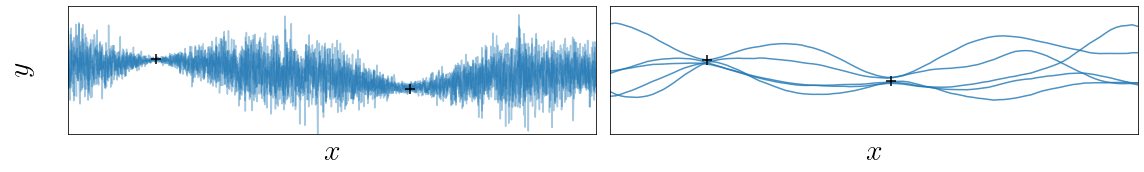

In [67]:
# mean_field_cov = MeanFieldCov(num_basis_dim=1)
# add_no_noise = AddNoNoise()

np.random.seed(0)
torch.manual_seed(0)

# mean_field_conv_gnp_path = './models/innerprod-convGNP'

# model = StandardConvGNP(input_dim=1,
#                         covariance=mean_field_cov,
#                         add_noise=add_no_noise,
#                         num_noise_channels=0)
# model.load_state_dict(torch.load(mean_field_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])

inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])

np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context'][:, :2, :]
x_target = data['x_target']
y_context = data['y_context'][:, :2, :]
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, 1000)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = model_output
cov = torch.diag_embed(torch.diagonal(cov, dim1=1, dim2=2))
mean, cov, cov_plus_noise = [v.detach().numpy() for v in (mean, cov, cov_plus_noise)]

chol = np.linalg.cholesky(cov[0] + 1e-5 * np.eye(cov[0].shape[0]))

samples = np.random.normal(size=(chol.shape[0], num_samples))
samples = mean[:, :, 0] + (chol @ samples).T

plt.figure(figsize=(16, 2.5))
plt.subplot(1, 2, 1)
plt.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context',
            zorder=2)

# plt.plot(x_plot[0, :, 0],
#          mean[0, :, 0],
#          color='blue',
#          alpha=0.3)

plt.plot(x_plot_rep.T,
         samples.T,
         color='tab:blue',
         alpha=0.4,
         zorder=1)

# plt.title('ConvCNP', fontsize=25)
plt.xlim([xmin, xmax])
plt.ylim([-3.5, 3.5])
plt.xticks([])
plt.yticks([])
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$y$\n', fontsize=30)
# plt.tight_layout()
# plt.savefig('./plots/meanfield-convGNP.pdf')
# plt.show()



inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])

np.random.seed(2)
torch.manual_seed(2)

data = list(gen)[0]

x_context = data['x_context'][:, :2, :]
x_target = data['x_target']
y_context = data['y_context'][:, :2, :]
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

chol = np.linalg.cholesky(cov[0] + 1e-5 * np.eye(cov[0].shape[0]))

samples = np.random.normal(size=(chol.shape[0], num_samples))
samples = mean[:, :, 0] + (chol @ samples).T

# plt.figure(figsize=(7.2, 2.85))
plt.subplot(1, 2, 2)
plt.scatter(x_context[0, :, 0],
            y_context[0, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context',
            zorder=2)

# plt.plot(x_plot[0, :, 0],
#          mean[0, :, 0],
#          color='blue',
#          alpha=0.3)

plt.plot(x_plot_rep.T,
         samples.T,
         color='tab:blue',
         alpha=0.8,
         zorder=1)

# plt.title('ConvGNP', fontsize=25)
plt.xlim([xmin, xmax])
plt.ylim([-3.5, 3.5])
plt.xticks([])
plt.yticks([])
plt.xlabel('$x$', fontsize=30)
# plt.ylabel('$y$', fontsize=30)
plt.tight_layout()
plt.savefig('./plots/intro-plots-new.pdf')
plt.show()